In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("./data/cnr.csv",parse_dates=['Date'],index_col=['Date'])
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2022-03-11,163.91,165.02,160.87,160.98,1322020
2022-03-14,160.82,161.99,157.82,158.26,911835
2022-03-15,159.87,160.10,156.27,157.86,980599
2022-03-16,158.61,162.02,157.89,161.54,850103
2022-03-17,161.59,161.59,159.17,161.22,807653


In [2]:
df = df[['Close']]
df

,Close
Date,
2022-03-11,160.98
2022-03-14,158.26
2022-03-15,157.86
2022-03-16,161.54
2022-03-17,161.22
...,...
2024-03-04,175.97
2024-03-05,176.19
2024-03-06,171.58


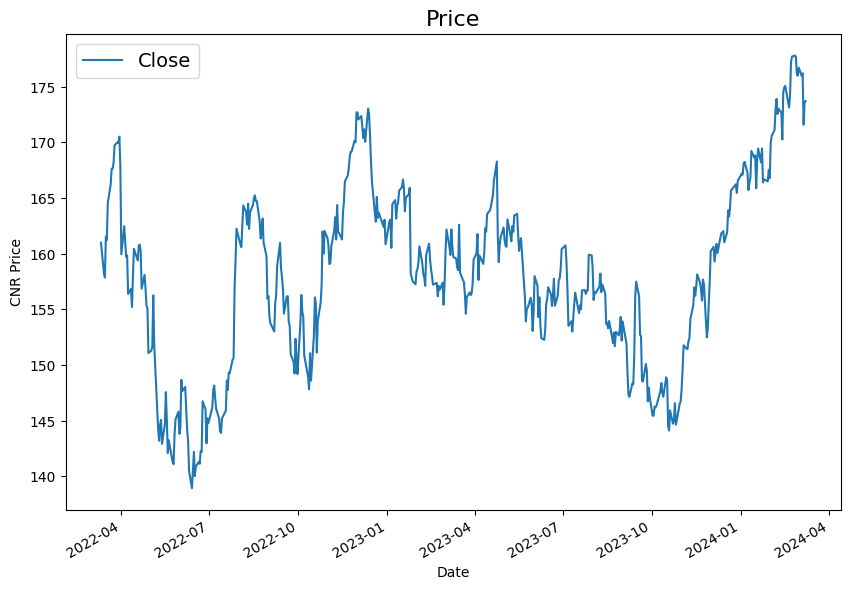

In [3]:
import matplotlib.pyplot as plt
df.plot(figsize=(10,7))
plt.ylabel('CNR Price')
plt.title('Price', fontsize=16)
plt.legend(fontsize=14)

In [4]:
timesteps = df.index.to_numpy()
prices = df["Close"].to_numpy()

timesteps[:10], prices[:10]

(array(['2022-03-11T00:00:00.000000000', '2022-03-14T00:00:00.000000000',
        '2022-03-15T00:00:00.000000000', '2022-03-16T00:00:00.000000000',
        '2022-03-17T00:00:00.000000000', '2022-03-18T00:00:00.000000000',
        '2022-03-21T00:00:00.000000000', '2022-03-22T00:00:00.000000000',
        '2022-03-23T00:00:00.000000000', '2022-03-24T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([160.98, 158.26, 157.86, 161.54, 161.22, 164.52, 166.21, 167.6 ,
        167.64, 168.14]))

In [5]:
split_size = int(0.8*len(prices))
X_train, y_train = timesteps[:split_size], prices[:split_size]
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train),len(y_train),len(X_test),len(y_test)

(400, 400, 101, 101)

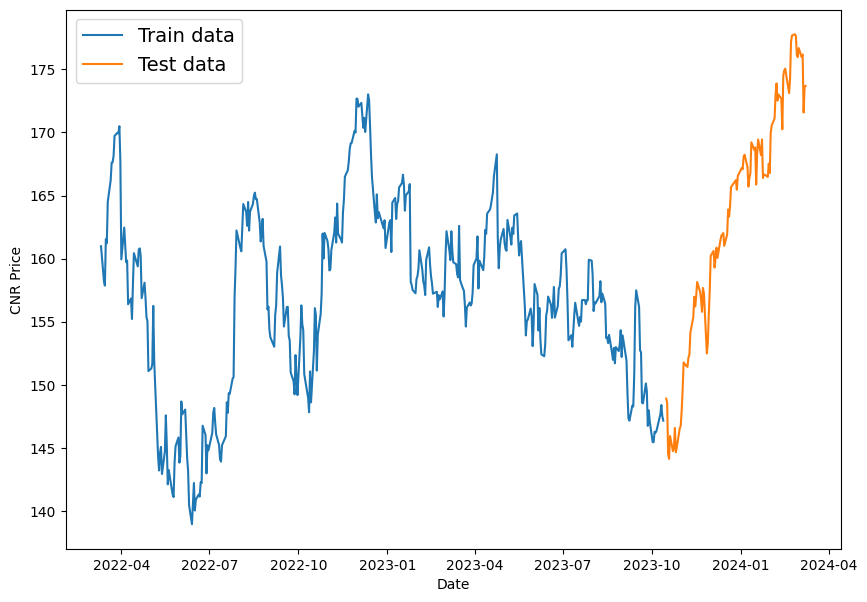

In [6]:
plt.figure(figsize=(10, 7))
plt.plot(X_train, y_train, label="Train data") 
plt.plot(X_test, y_test, label="Test data")    
plt.xlabel("Date")
plt.ylabel("CNR Price")
plt.legend(fontsize=14)
plt.show();


In [7]:
import tensorflow as tf

def mean_absolute_scaled_error(y_true, y_pred):
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:]-y_true[:-1]))

  return mae/mae_naive_no_season

def evaluate_preds(y_true,y_pred):
  y_true = tf.cast(y_true,dtype=tf.float32)

  y_pred = tf.cast(y_pred, dtype=tf.float32)

  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)

  rmse = tf.sqrt(mse)
  mape = mean_absolute_scaled_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return{'mae': mae.numpy(),
         'mse': mse.numpy(),
         'rmse': rmse.numpy(),
         'mape': mape.numpy(),
         'mase': mase.numpy()}

2024-03-13 18:24:53.236229: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
HORIZON = 1
WINDOW_SIZE = 7

def get_labelled_windows(x,horizon=1):
  return x[:,:-horizon], x[:, -horizon:]

test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)

def make_windows(x, window_size=7, horizon=1):
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T

  windowed_array = x[window_indexes]
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(494, 494)

In [9]:
def make_train_test_splits(windows, labels, test_split=0.2):
  split_size = int(len(windows)*(1-test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows, test_windows, train_labels, test_labels

train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(395, 99, 395, 99)

In [10]:
import os
def create_model_checkpoint(model_name, save_path='model_experiments'):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path,model_name),
                                            verbose=0,
                                            monitor = 'val_loss',
                                            save_best_only=True)

In [11]:
from tensorflow.keras import layers
tf.random.set_seed(42)

inputs = layers.Input(shape=(WINDOW_SIZE))

x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)

# x = layers.LSTM(64, activation='relu' ,return_sequences=True)(x)


x = layers.LSTM(128, activation='relu')(x)


x = layers.Dense(32, activation='relu')(x)

# x = layers.Dense(16, activation='relu')(x)

output = layers.Dense(HORIZON)(x)

model = tf.keras.Model(inputs=inputs, outputs=output, name='model_lstm')

model.compile(loss='mae',
               optimizer='Adam')

model.fit(train_windows,
           train_labels,
           epochs = 100,
           verbose=0,
           batch_size=128,
           validation_data=(test_windows, test_labels),
           callbacks=[create_model_checkpoint(model_name=model.name)])

INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


In [12]:
model.evaluate(test_windows, test_labels)

4/4 [==============================] - 0s 3ms/step - loss: 2.2585


2.2584826946258545

In [13]:
def make_preds(model, input_data):
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

model_preds = make_preds(model, test_windows)
model__results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_preds)
model__results

4/4 [==============================] - 0s 2ms/step


{'mae': 2.2584822,
 'mse': 7.564929,
 'rmse': 2.7504416,
 'mape': 1.9811239,
 'mase': 1.9811239}

In [14]:
def plot_time_series(timesteps, values, format='-', start=0, end=None, label=None):
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("CNR Price")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

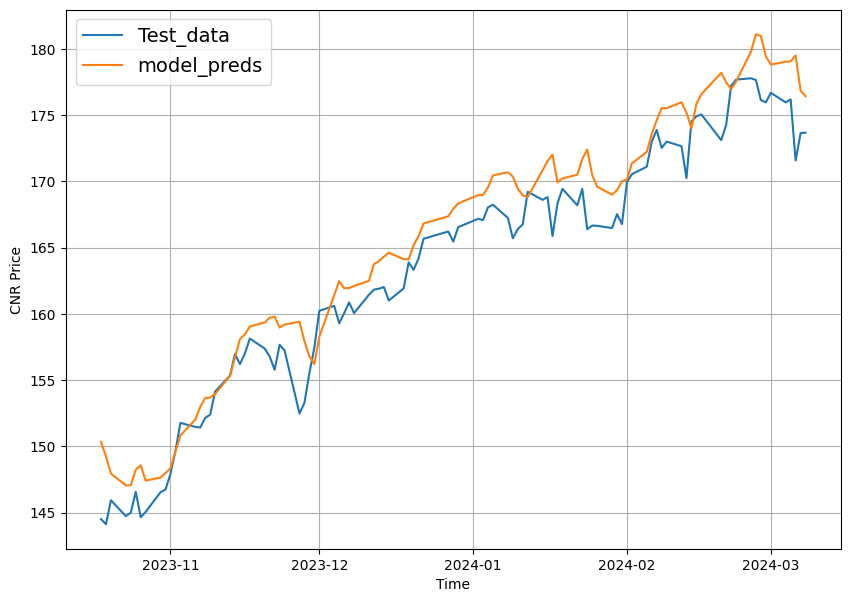

In [15]:

plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_preds, label="model_preds")

13/13 [==============================] - 0s 2ms/step


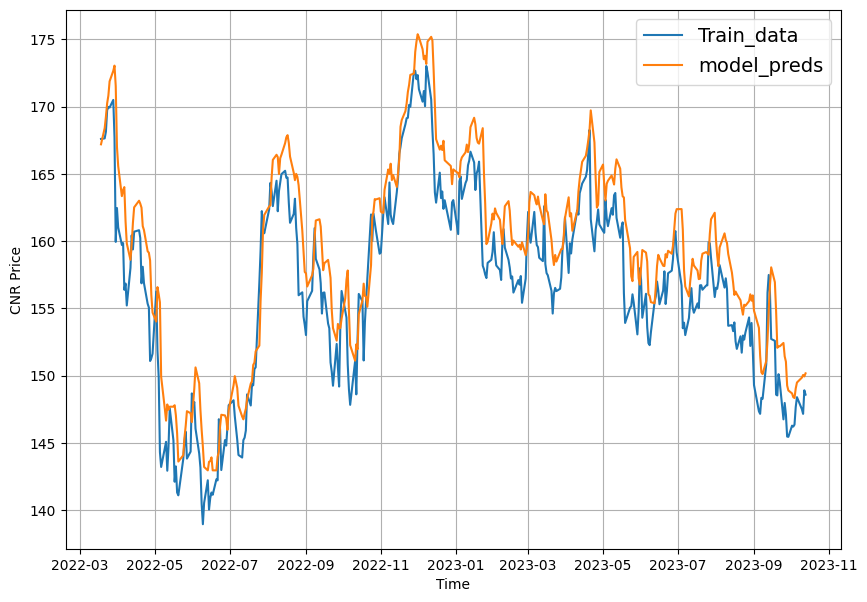

In [16]:
model_preds_train = make_preds(model, train_windows)
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-len(train_windows):], values=train_labels[:, 0], label="Train_data")
plot_time_series(timesteps=X_train[-len(train_windows):], values=model_preds_train, format="-", label="model_preds")